# Qibolab v0.1.6 1Q emulator demo for QuTiP engine

Results updated on: 11 May 2024

## Example 0: Emulator Setup

In [1]:
# add directory of emulator platform to QIBOLAB_PLATFORMS environment variable
import pathlib, os
emulator_path = pathlib.Path(os.path.abspath('')).parent/'tests/emulators/'
os.environ["QIBOLAB_PLATFORMS"] = emulator_path.as_posix() 

# create emulator platform as per any other platforms
from qibolab import create_platform
emulator_platform = create_platform("default_q0")
pulse_simulator = emulator_platform.instruments['pulse_simulator']
simulation_engine = pulse_simulator.simulation_engine

# import visualization tools
from qibolab_visualization.emulator import print_hamiltonian, plot_fidelities #plot_fidelity_history

INFO:root:ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine
INFO:root:emulator qubits: ['0']
INFO:root:emulator couplers: []
INFO:root:runcard qubits: [0]
INFO:root:runcard couplers: []
INFO:root:sampling rate: 4.5GHz
INFO:root:simulation sampling boost: 10
[Qibo 0.2.6|INFO|2024-05-15 23:15:33]: Loading platform ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine
INFO:qibo.config:Loading platform ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine


Hilbert space structure:  ['0']
Hilbert space dimensions:  [3]


In [2]:
print_hamiltonian(simulation_engine.model_config)

Dictionary


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



---------------------
One-body drift terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Two-body drift terms:
---------------------
None
---------------------
One-body drive terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Dissipative terms:
---------------------
>> t1 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

>> t2 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------


## Example 1: Simulation of Pulse Sequence

### Preparation: Construct Pulse Sequence

PulseSequence
DrivePulse(0, 35.55555555555556, 0.240451, 5_090_167_234.445013, 0, Drag(4, 2.43058), drive-0, 0)
ReadoutPulse(37.77777777777778, 4977.777777777777, 0.03, 7_301_661_824.000001, 0, Rectangular(), readout-0, 0)


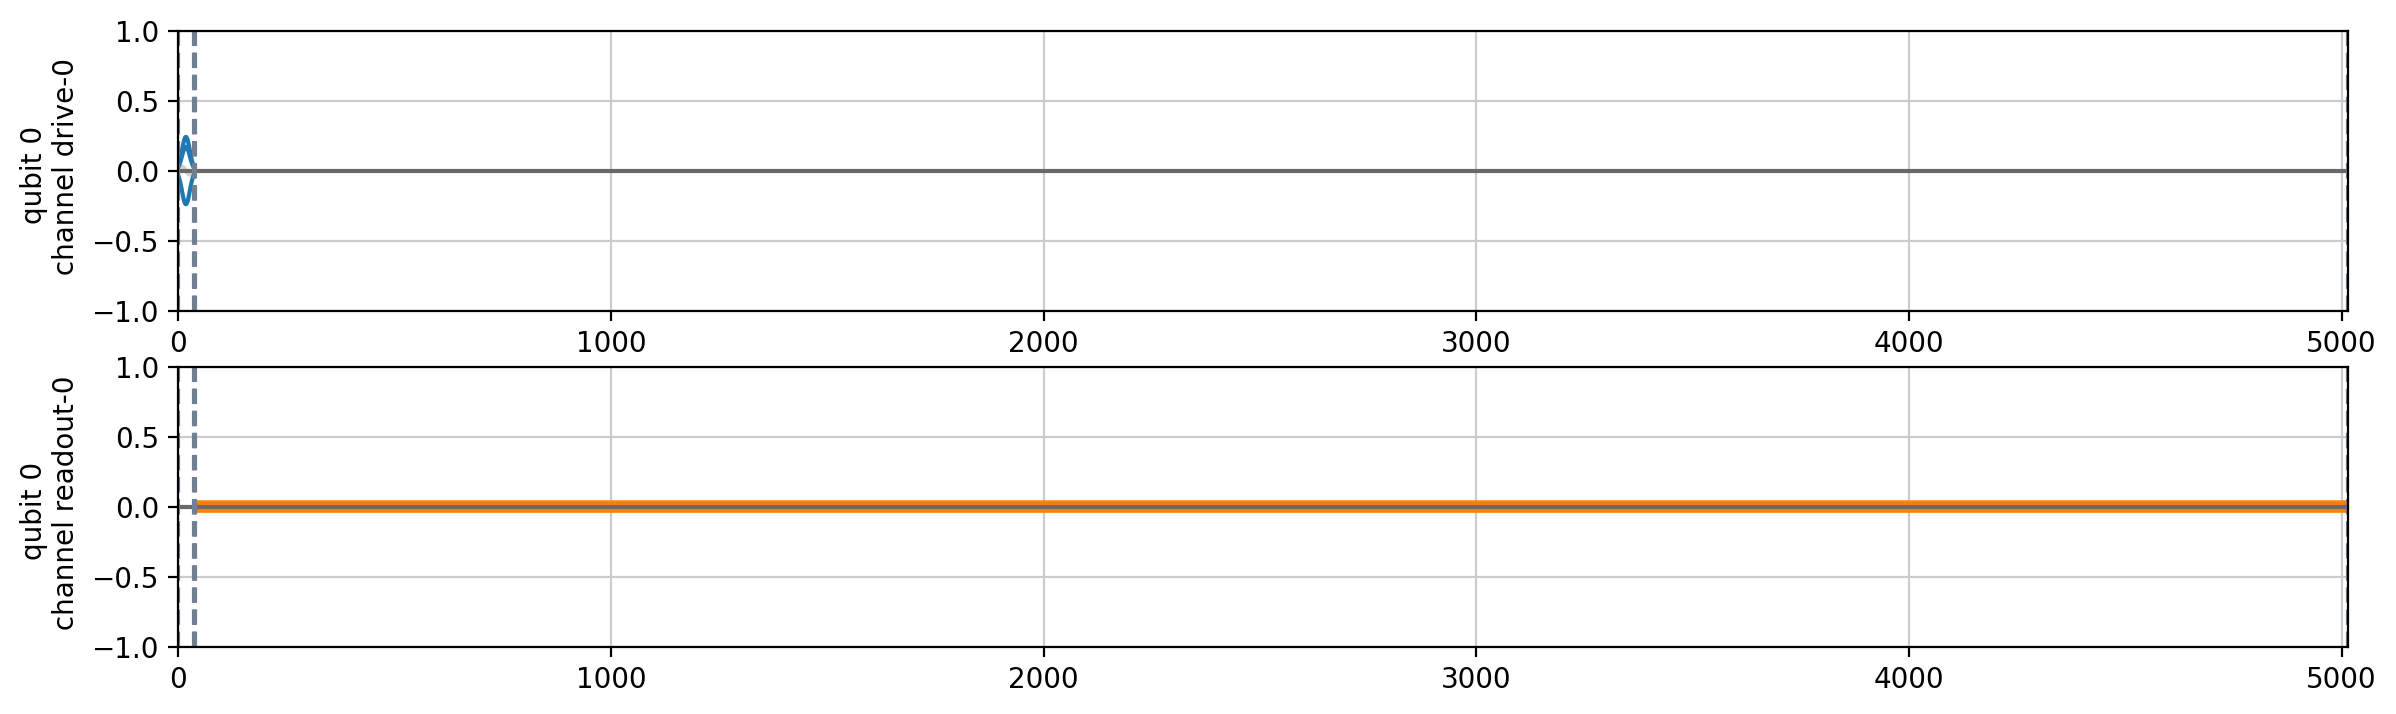

5015.555555555555
37.77777777777778
4977.777777777777


In [3]:
from qibolab.pulses import (
    DrivePulse,
    ReadoutPulse,
    PulseSequence,
    Rectangular,
    Gaussian,
    Drag
)

# Define PulseSequence
sequence = PulseSequence()

# Add some pulses to the pulse sequence
'''
pulse_x0 = DrivePulse(
    start=0,
    frequency=5_090_167_234.445013,
    amplitude=0.240451, 
    duration=35.55555555555556, 
    relative_phase=0,
    shape=Drag(4, 2.43058),
    channel='drive-0',
    qubit=0,
    )
    
pulse_r0 = ReadoutPulse(
    start=10/4.5+x0_pulse.duration,
    frequency=1_622_591_516, 
    amplitude=0.03, 
    duration=10/4.5,
    relative_phase=0,
    shape=Rectangular(),
    channel='readout-0',
    qubit=0,
    )
'''
pulse_x0 = emulator_platform.create_RX_pulse(qubit=0, start=0)
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=(170/4.5))

sequence = PulseSequence()
sequence.add(pulse_x0)
sequence.add(pulse_r0)

print(sequence)
sequence.plot()
print(sequence.duration)
print(pulse_r0.start)
print(pulse_r0.duration)

### Execution: Emulator Pulse and Generate Pulse Sequence

In [4]:
from qibolab.execution_parameters import ExecutionParameters

# Connects to lab instruments using the details specified in the calibration settings.
emulator_platform.instruments['pulse_simulator'].connect()

# Configures instruments using the loaded calibration settings.
emulator_platform.instruments['pulse_simulator'].setup()

# Turn off readout error
emulator_platform.instruments['pulse_simulator'].readout_error = None

# Executes a pulse sequence.
options = ExecutionParameters(nshots=1000)#, relaxation_time=100)
results = emulator_platform.execute_pulse_sequence(sequence, options=options)
#results = pulse_simulator.play({0:0}, {}, sequence, options=options)

# Disconnect from the instruments
emulator_platform.instruments['pulse_simulator'].disconnect()

[Qibo 0.2.6|INFO|2024-05-15 23:15:33]: Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
[Qibo 0.2.6|INFO|2024-05-15 23:15:33]: Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
[Qibo 0.2.6|INFO|2024-05-15 23:15:33]: Minimal execution time (sequence): 0.3050155555555556
INFO:qibo.config:Minimal execution time (sequence): 0.3050155555555556


 Total run time:   1.55s*] Elapsed 1.55s / Remaining 00:00:00:00[*********38%           ] Elapsed 0.70s / Remaining 00:00:00:01
simulation time 1.5542193750000002


[Qibo 0.2.6|INFO|2024-05-15 23:15:35]: Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.


In [5]:
simulated_states = results['simulation']['output_states']
final_state = simulated_states[-1]
final_state

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.18893488+0.23379891j]
 [-0.93780292-0.17355788j]
 [-0.00666959+0.00043518j]]

In [6]:
print(f'final state norm: {final_state.norm()}')

final state norm: 0.9999998238614657


In [7]:
results[list(results.keys())[1]].samples

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [8]:
# Generate time list
import numpy as np
sequence_duration = results['simulation']['sequence_duration']
simulation_dt = results['simulation']['simulation_dt']
simulation_time = results['simulation']['simulation_time']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

[0] 0.09035832318965352
[1] 0.90959665176597
[2] 4.4672767338981115e-05


/var/folders/xt/z7_sd24x7mgbzdyf93ck8ph00000gn/T/ipykernel_55174/2963860698.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fidelities = simulation_engine.compute_fidelities(simulated_states)


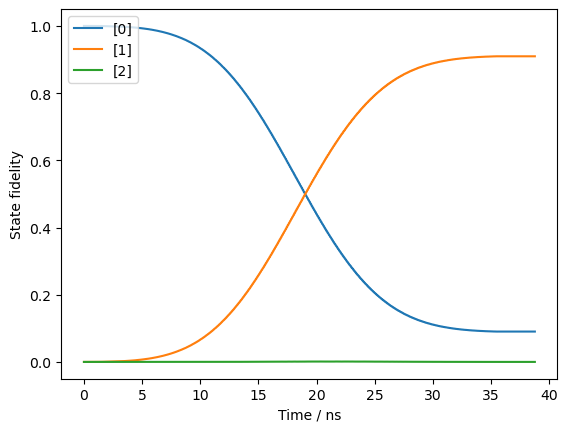

In [9]:
fidelities = simulation_engine.compute_fidelities(simulated_states)
plot_fidelities(fidelities,sim_time_list,time_label='Time / ns');

### Print out the Pulse Sequence

In [10]:
from qibolab.instruments.emulator.pulse_simulator import ps_to_waveform_dict, truncate_ro_pulses
pulse_simulator = emulator_platform.instruments['pulse_simulator']
channel_waveforms = ps_to_waveform_dict(
            truncate_ro_pulses(sequence),
            pulse_simulator.platform_to_simulator_channels,
            pulse_simulator.sampling_rate,
            pulse_simulator.sim_sampling_boost,
            pulse_simulator.runcard_duration_in_dt_units,
        )

### Plot the Simulated Waveform

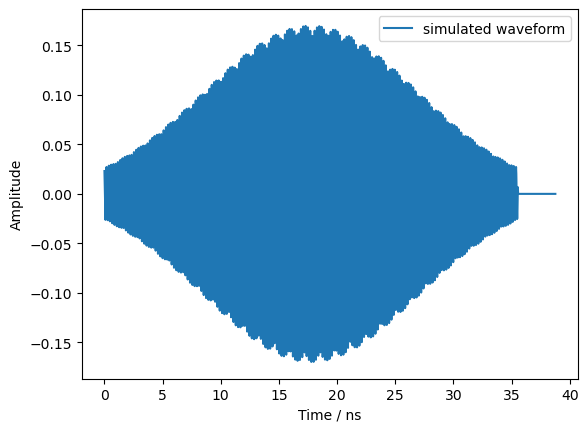

In [11]:
import matplotlib.pyplot as plt
plt.plot(channel_waveforms['time'],channel_waveforms['channels']['D-0'], label='simulated waveform')
plt.xlabel('Time / ns')
plt.ylabel('Amplitude')
plt.legend()

### Perform sampling and apply readout noise

In [12]:
from qibolab.instruments.emulator.pulse_simulator import get_samples

ro_qubit_list = [pulse_r0.qubit]
ro_reduced_dm, rdm_qubit_list = pulse_simulator.simulation_engine.qobj_to_reduced_dm(final_state, ro_qubit_list)
samples = get_samples(1000, ro_reduced_dm, rdm_qubit_list, pulse_simulator.simulation_engine.qid_nlevels_map)

In [13]:
import numpy as np
from qibolab.instruments.emulator.pulse_simulator import apply_readout_noise

readout_error = {0: [0.1, 0.1], 1: [0.1, 0.1]}
noisy_samples = apply_readout_noise(samples, readout_error)
print('samples without noise: ', samples[0][:20], np.sum(noisy_samples[0]))
print('samples with noise:    ', noisy_samples[0][:20], np.sum(samples[0]))

samples without noise:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 851
samples with noise:     [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 912


## Example 2. Pulse-level Simulation of X0 Gate

### Preparation: 1. Construct qibolab backend with transpiler settings

In [14]:
# reset pulse simulator; resets readout_error to model_config values
pulse_simulator.update()
simulation_engine = pulse_simulator.simulation_engine
print('readout error: ',emulator_platform.instruments['pulse_simulator'].readout_error)
#print('pulse sequence history: ', emulator_platform.instruments['pulse_simulator'].pulse_sequence_history)
#print('pulse sequences simulated: ', len(emulator_platform.instruments['pulse_simulator'].simulation_engine.pulse_sim_history))

# option 1, using default transpiler
from qibolab.backends import QibolabBackend
from qibo.transpiler.pipeline import Passes

emulator_backend = QibolabBackend(platform=emulator_platform)
emulator_backend.transpiler = Passes(connectivity=emulator_backend.platform.topology)
emulator_backend.transpiler.passes = list(emulator_backend.transpiler.passes[i] for i in [0,1,3])
emulator_backend.transpiler.passes

Hilbert space structure:  ['0']
Hilbert space dimensions:  [3]
readout error:  {0: [0.01, 0.02]}


In [15]:
zerostate = simulation_engine.psi0.copy()

### Preparation: 2. Prepare test state - X0 gate

In [16]:
from qutip import Qobj
import numpy as np

# prepare test state
qibo_statevector = np.array([0.,1.])
sim_statevector = np.array([0.,1.,0.])
teststate = simulation_engine.make_arbitrary_state(sim_statevector)

# initialize with |00> state
#simulation_engine.psi0 = zerostate
# initialize with test state
simulation_engine.psi0 = teststate

print("qibo test statevector", qibo_statevector)
print(simulation_engine.psi0)

qibo test statevector [0. 1.]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]


### Preparation: 3. Construct the Circuit

In [17]:
from qibo.models import Circuit
from qibo import gates

circ_x0 = Circuit(1)
circ_x0.add(gates.X(0))
circ_x0.add(gates.M(*range(1)))
#circ_x0_job = circ_x0(nshots=1000)
circ_x0_job = circ_x0(qibo_statevector,nshots=1000)
ideal_x0_results = circ_x0_job.frequencies()

print(circ_x0.draw())
print(ideal_x0_results)
circ_x0_job.state()

[Qibo 0.2.6|INFO|2024-05-15 23:15:35]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


q0: ─X─M─
Counter({'0': 1000})


array([1.+0.j, 0.+0.j])

### Execution: Perform Pulse-level Simulation of the X0 Gate

In [18]:
#x0
backend_job = emulator_backend.execute_circuit(circ_x0, nshots=1000)

[Qibo 0.2.6|ERROR|2024-05-15 23:15:35]: x is not a native gate.
ERROR:qibo.config:x is not a native gate.
[Qibo 0.2.6|INFO|2024-05-15 23:15:35]: Connecting to instrument <qibolab.instruments.emulator.pulse_simulator.PulseSimulator object at 0x1541028e0>.
INFO:qibo.config:Connecting to instrument <qibolab.instruments.emulator.pulse_simulator.PulseSimulator object at 0x1541028e0>.
[Qibo 0.2.6|INFO|2024-05-15 23:15:35]: Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
[Qibo 0.2.6|INFO|2024-05-15 23:15:35]: Minimal execution time (sequence): 0.3050488888888889
INFO:qibo.config:Minimal execution time (sequence): 0.3050488888888889


 [*********86%********   ] Elapsed 2.31s / Remaining 00:00:00:00[*********52%           ] Elapsed 1.33s / Remaining 00:00:00:01[*********62%**         ] Elapsed 1.60s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
backend_job.frequencies()

Counter({'0': 949, '1': 51})

## Example 3: Sweeper

### Preparation: Construct Reference Pulse Sequence

Hilbert space structure:  ['0']
Hilbert space dimensions:  [3]
readout error:  {0: [0.01, 0.02]}


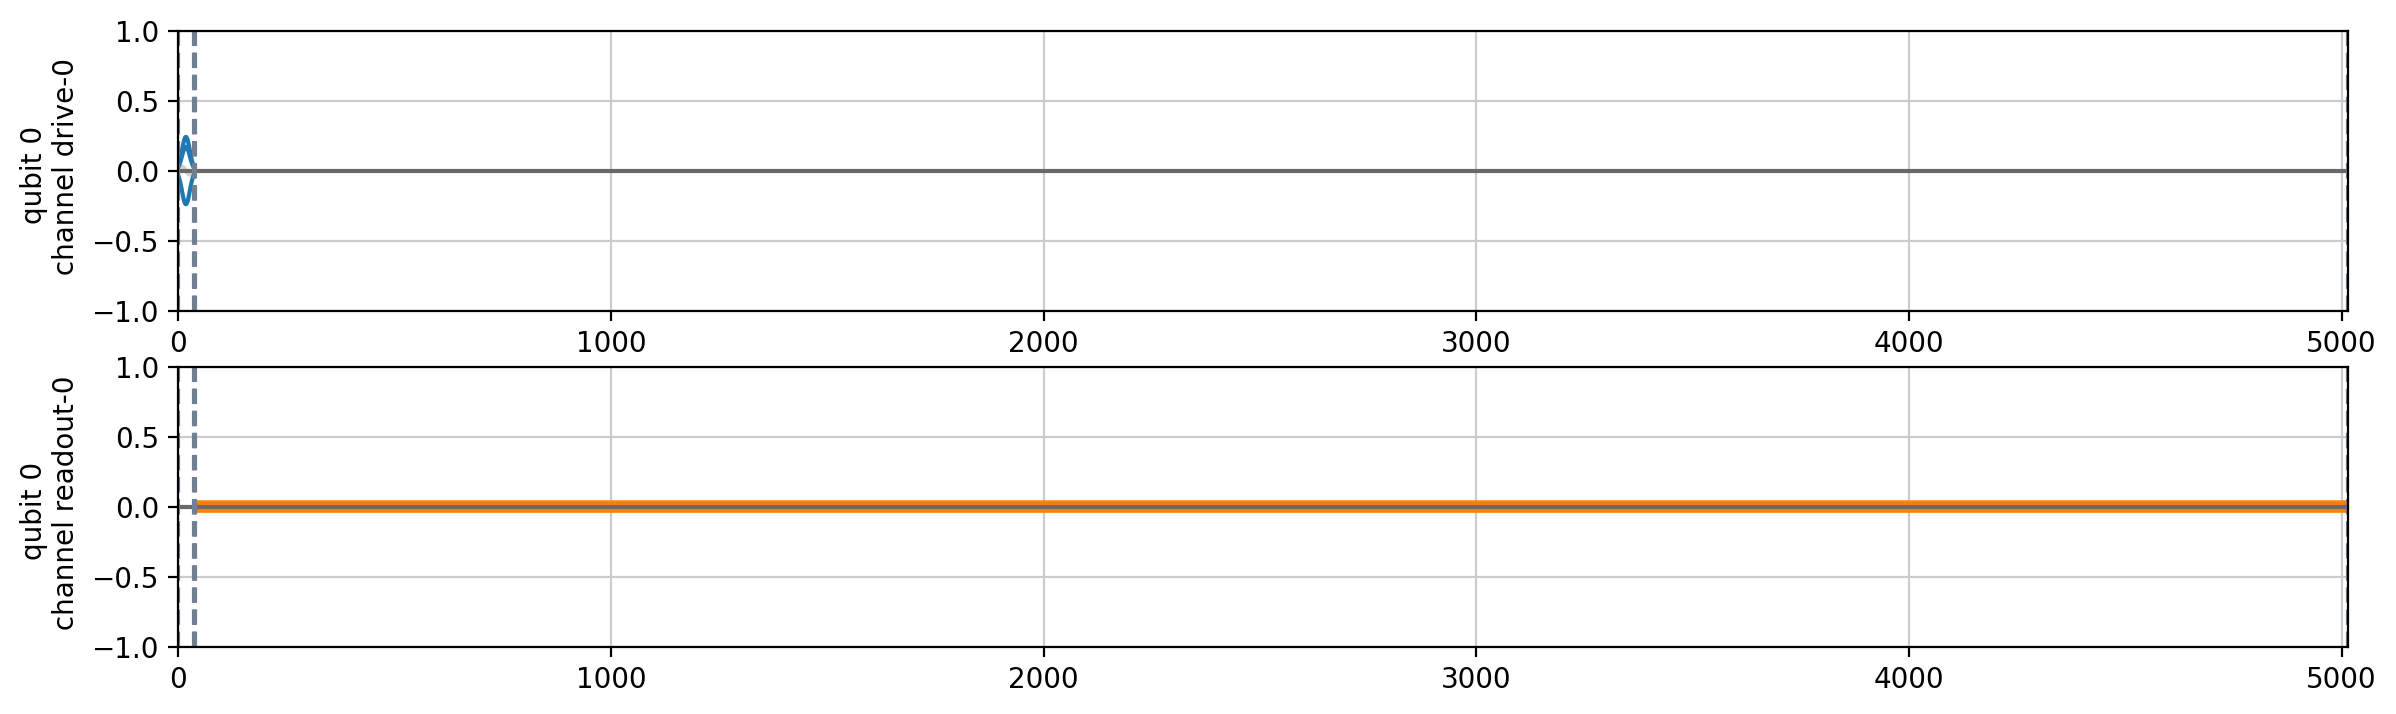

5015.555555555555
38.666666666666664
4977.777777777777


In [20]:
import numpy as np
from qibolab.pulses import PulseSequence
from qibolab import ExecutionParameters

# reset pulse simulator
pulse_simulator.update()
simulation_engine = pulse_simulator.simulation_engine
print('readout error: ',emulator_platform.instruments['pulse_simulator'].readout_error)
#print('pulse sequence history: ', emulator_platform.instruments['pulse_simulator'].pulse_sequence_history)
#print('pulse sequences simulated: ', len(emulator_platform.instruments['pulse_simulator'].simulation_engine.pulse_sim_history))

sequence = PulseSequence()
pulse_x0 = emulator_platform.create_RX_pulse(qubit=0, start=0)
sequence.add(pulse_x0)
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=(165/4.5+5/4.5))
sequence.add(pulse_r0)
sequence.plot()
print(sequence.duration)
print(pulse_r0.start+4/4.5)
print(pulse_r0.duration)

### Check: Simulate Reference Pulse Sequence

In [21]:
from qibolab.execution_parameters import ExecutionParameters

# Connects to lab instruments using the details specified in the calibration settings.
emulator_platform.instruments['pulse_simulator'].connect()

# Configures instruments using the loaded calibration settings.
emulator_platform.instruments['pulse_simulator'].setup()

# Executes a pulse sequence.
options = ExecutionParameters(nshots=1000)
results = emulator_platform.execute_pulse_sequence(sequence, options=options)

# Disconnect from the instruments
emulator_platform.instruments['pulse_simulator'].disconnect()

[Qibo 0.2.6|INFO|2024-05-15 23:15:38]: Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
[Qibo 0.2.6|INFO|2024-05-15 23:15:38]: Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
INFO:qibo.config:Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.
[Qibo 0.2.6|INFO|2024-05-15 23:15:38]: Minimal execution time (sequence): 0.3050155555555556
INFO:qibo.config:Minimal execution time (sequence): 0.3050155555555556


 [********100%***********] Elapsed 1.43s / Remaining 00:00:00:00

[Qibo 0.2.6|INFO|2024-05-15 23:15:40]: Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.


 Total run time:   1.43s
simulation time 1.426952625000001


INFO:qibo.config:Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine.


[0] 0.09035832318965352
[1] 0.90959665176597
[2] 4.4672767338981115e-05


/var/folders/xt/z7_sd24x7mgbzdyf93ck8ph00000gn/T/ipykernel_55174/315560334.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fidelities = simulation_engine.compute_fidelities(simulated_states)


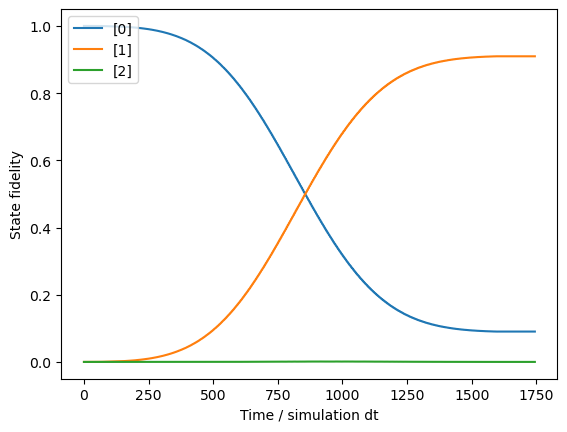

In [22]:
simulated_states = results['simulation']['output_states']
fidelities = simulation_engine.compute_fidelities(simulated_states)
plot_fidelities(fidelities);

In [23]:
from qibolab.sweeper import Sweeper, Parameter

parameter = Parameter.duration
parameter2 = Parameter.amplitude
parameter_range = np.linspace(155/4.5, 165/4.5, num=3)
parameter2_range = np.linspace(0.23045125169257026, 0.25045125169257026, num=3)
sweeper = Sweeper(parameter, parameter_range, [pulse_x0])
sweeper2 = Sweeper(parameter2, parameter2_range, [pulse_x0])
'''
parameter_range = np.linspace(-5/4.5, 5/4.5, num=3)
parameter2_range = np.linspace(-0.01, 0.01, num=3)
sweeper = Sweeper(parameter, parameter_range, [pulse_x0], type=SweeperType.OFFSET)
sweeper2 = Sweeper(parameter2, parameter2_range, [pulse_x0], type=SweeperType.OFFSET)
'''
print(sweeper)
print(sweeper2)

Sweeper(parameter=<Parameter.duration: 3>, values=array([34.44444444, 35.55555556, 36.66666667]), pulses=[DrivePulse(0, 35.55555555555556, 0.240451, 5_090_167_234.445013, 0, Drag(4, 2.43058), drive-0, 0)], qubits=None, couplers=None, type=<SweeperType.ABSOLUTE: functools.partial(<function SweeperType.<lambda> at 0x1540f74c0>)>)
Sweeper(parameter=<Parameter.amplitude: 2>, values=array([0.23045125, 0.24045125, 0.25045125]), pulses=[DrivePulse(0, 35.55555555555556, 0.240451, 5_090_167_234.445013, 0, Drag(4, 2.43058), drive-0, 0)], qubits=None, couplers=None, type=<SweeperType.ABSOLUTE: functools.partial(<function SweeperType.<lambda> at 0x1540f74c0>)>)


In [24]:
sweep_results = emulator_platform.sweep(sequence, ExecutionParameters(), sweeper)

[Qibo 0.2.6|INFO|2024-05-15 23:15:40]: Minimal execution time (sweep): 3.7480311466666665
INFO:qibo.config:Minimal execution time (sweep): 3.7480311466666665


sweep param: duration
values [34.44444444 35.55555556 36.66666667]
 Total run time:   1.43s*] Elapsed 1.43s / Remaining 00:00:00:00[*******  32%           ] Elapsed 0.46s / Remaining 00:00:00:00[*********38%           ] Elapsed 0.60s / Remaining 00:00:00:00
simulation time 1.4304952919999998
 [*********59%**         ] Elapsed 0.84s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.42s*] Elapsed 1.42s / Remaining 00:00:00:00[*********74%*****      ] Elapsed 1.04s / Remaining 00:00:00:00
simulation time 1.4250122909999998


[0] 0.10552673767685397
[1] 0.8944282874192079
[2] 4.452686264802842e-05
[0] 0.09035832318965352
[1] 0.90959665176597
[2] 4.4672767338981115e-05
[0] 0.07846788576725075
[1] 0.9214921159466745
[2] 3.9627423225530866e-05


/var/folders/xt/z7_sd24x7mgbzdyf93ck8ph00000gn/T/ipykernel_55174/2402698541.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fidelities = simulation_engine.compute_fidelities(state_history)


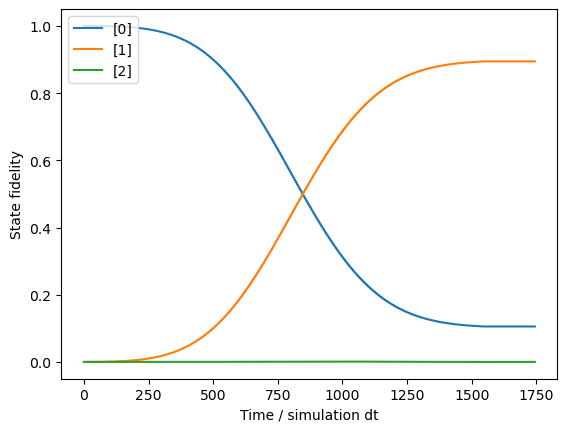

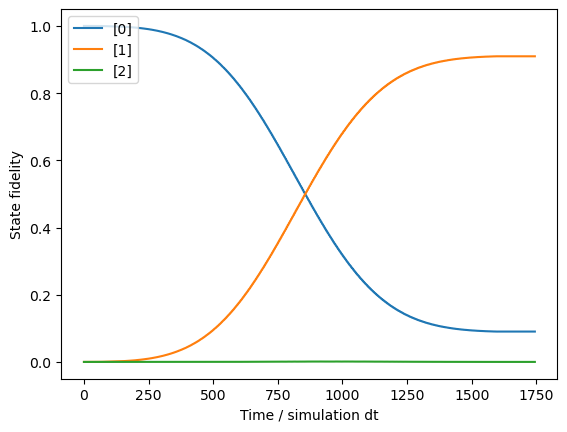

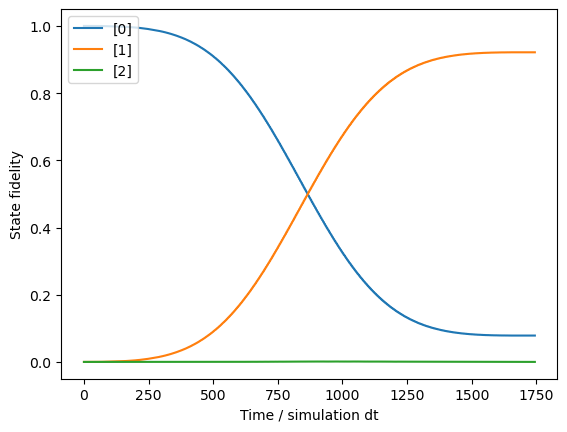

In [25]:
for state_history in sweep_results['simulation']['output_states']:
    fidelities = simulation_engine.compute_fidelities(state_history)
    plot_fidelities(fidelities)

In [26]:
# output only final state
emulator_platform.instruments['pulse_simulator'].output_state_history = False
sweep_results_2 = emulator_platform.sweep(sequence, ExecutionParameters(), sweeper, sweeper2)

[Qibo 0.2.6|INFO|2024-05-15 23:15:45]: Minimal execution time (sweep): 11.24409344
INFO:qibo.config:Minimal execution time (sweep): 11.24409344


sweep param: duration
values [34.44444444 35.55555556 36.66666667]
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 Total run time:   1.32s*] Elapsed 1.32s / Remaining 00:00:00:00
simulation time 1.3159031250000002
 [*********61%**         ] Elapsed 0.84s / Remaining 00:00:00:00[*********60%**         ] Elapsed 0.78s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.20s*] Elapsed 1.20s / Remaining 00:00:00:00[*********71%****       ] Elapsed 0.87s / Remaining 00:00:00:00
simulation time 1.2015759580000012
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 Total run time:   1.28s*] Elapsed 1.28s / Remaining 00:00:00:00[**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00
simulation time 1.2801976249999996
 [****     16%           ] Elapsed 0.26s / Remaining 00:00:00:01[          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.28s*] Elapsed 1.28s / Remaining 00:00:00:00
simulation time 1.2823111659999995
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 [*********86%********   ] Elapsed 1.13s / Remaining 00:00:00:00[*********48%           ] Elapsed 0.65s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.90s*] Elapsed 1.90s / Remaining 00:00:00:00
simulation time 1.899859750000001
 Total run time:   1.39s*] Elapsed 1.39s / Remaining 00:00:00:00[*********82%*******    ] Elapsed 1.18s / Remaining 00:00:00:00
simulation time 1.3870172499999995


In [27]:
from qibolab.instruments.emulator.pulse_simulator import make_array_index_list

final_states_array = sweep_results_2['simulation']['output_states']
shape = final_states_array.shape
index_list = make_array_index_list(shape)
fidelities = {}
for index in index_list:
    pulse_simulator.merge_sweep_results(fidelities, simulation_engine.compute_fidelities(final_states_array[tuple(index)]))

/var/folders/xt/z7_sd24x7mgbzdyf93ck8ph00000gn/T/ipykernel_55174/1114280416.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pulse_simulator.merge_sweep_results(fidelities, simulation_engine.compute_fidelities(final_states_array[tuple(index)]))


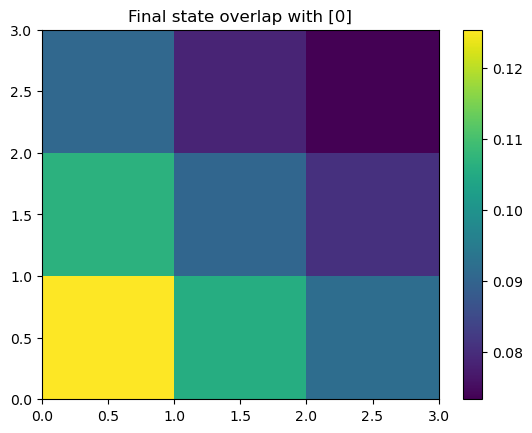

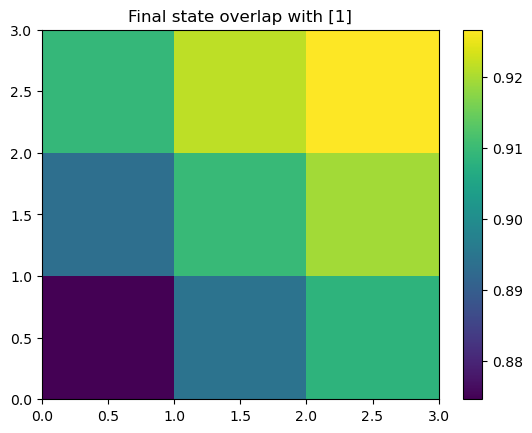

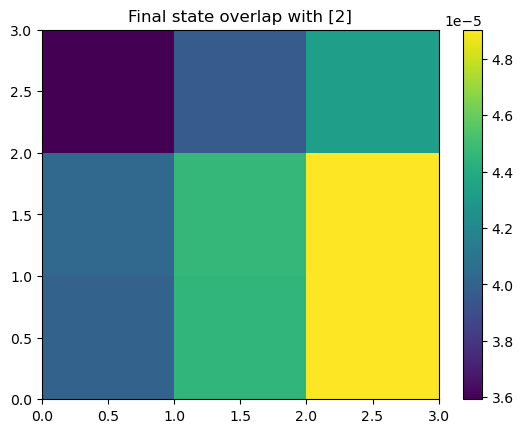

In [28]:
import matplotlib.pyplot as plt
for label in fidelities.keys():
    plt.figure()
    plt.pcolormesh(np.array(fidelities[label]).reshape([3,3]))
    plt.colorbar()
    plt.title(f'Final state overlap with {label}')
    plt.show()

## --- Version information for major packages used in the current Qibolab emulator example ---

In [29]:
%load_ext watermark

In [30]:
%watermark -v -p qibolab,qibo,qutip,matplotlib,numpy,scipy

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

qibolab   : 0.1.6
qibo      : 0.2.6
qutip     : 4.7.5
matplotlib: 3.8.0
numpy     : 1.26.4
scipy     : 1.12.0

